In [1]:
# Import the required libraries
import os
from tensorflow.keras.models import load_model
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, lit, when, avg
from pyspark.sql.functions import year, month, to_date
from pyspark.sql.window import Window
import plotly.express as px
import time
import pandas as pd
import matplotlib.pyplot as plt
import sys
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error,r2_score
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.callbacks import Callback
from datetime import datetime
import logging
logging.getLogger("tensorflow").setLevel(logging.FATAL)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import absl.logging
absl.logging.set_verbosity(absl.logging.FATAL)
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

In [2]:
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.5.3'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,197 kB]
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,632 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:13 http://security.ubuntu.com/ubuntu jammy-s

# **Data Pull, Clean and Exploration**

In [3]:
# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [4]:
from pyspark import SparkFiles
url = "https://kudata.s3.us-east-2.amazonaws.com/indexData.csv"
spark.sparkContext.addFile(url)
stock_data = spark.read.csv(SparkFiles.get("indexData.csv"), sep=',', header=True)
stock_data.show()

+-----+----------+----------+----------+----------+----------+----------+------+
|Index|      Date|      Open|      High|       Low|     Close| Adj Close|Volume|
+-----+----------+----------+----------+----------+----------+----------+------+
|  NYA|1965-12-31|528.690002|528.690002|528.690002|528.690002|528.690002|     0|
|  NYA|1966-01-03|527.210022|527.210022|527.210022|527.210022|527.210022|     0|
|  NYA|1966-01-04|527.840027|527.840027|527.840027|527.840027|527.840027|     0|
|  NYA|1966-01-05|531.119995|531.119995|531.119995|531.119995|531.119995|     0|
|  NYA|1966-01-06|532.070007|532.070007|532.070007|532.070007|532.070007|     0|
|  NYA|1966-01-07|532.599976|532.599976|532.599976|532.599976|532.599976|     0|
|  NYA|1966-01-10|533.869995|533.869995|533.869995|533.869995|533.869995|     0|
|  NYA|1966-01-11|534.289978|534.289978|534.289978|534.289978|534.289978|     0|
|  NYA|1966-01-12|533.340027|533.340027|533.340027|533.340027|533.340027|     0|
|  NYA|1966-01-13|534.400024

In [5]:
df = stock_data


In [6]:
# Ensure the Date column is in proper date format
df = df.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# Add Year and Month columns
df = df.withColumn("Year", year(col("Date"))) \
       .withColumn("Month", month(col("Date")))

# Show the result to verify
df.show()

+-----+----------+----------+----------+----------+----------+----------+------+----+-----+
|Index|      Date|      Open|      High|       Low|     Close| Adj Close|Volume|Year|Month|
+-----+----------+----------+----------+----------+----------+----------+------+----+-----+
|  NYA|1965-12-31|528.690002|528.690002|528.690002|528.690002|528.690002|     0|1965|   12|
|  NYA|1966-01-03|527.210022|527.210022|527.210022|527.210022|527.210022|     0|1966|    1|
|  NYA|1966-01-04|527.840027|527.840027|527.840027|527.840027|527.840027|     0|1966|    1|
|  NYA|1966-01-05|531.119995|531.119995|531.119995|531.119995|531.119995|     0|1966|    1|
|  NYA|1966-01-06|532.070007|532.070007|532.070007|532.070007|532.070007|     0|1966|    1|
|  NYA|1966-01-07|532.599976|532.599976|532.599976|532.599976|532.599976|     0|1966|    1|
|  NYA|1966-01-10|533.869995|533.869995|533.869995|533.869995|533.869995|     0|1966|    1|
|  NYA|1966-01-11|534.289978|534.289978|534.289978|534.289978|534.289978|     0|

In [7]:
df.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [8]:
# Recast the columns to DOUBLE
df = df.withColumn("Open", col("Open").cast("double")) \
               .withColumn("High", col("High").cast("double")) \
               .withColumn("Low", col("Low").cast("double")) \
               .withColumn("Close", col("Close").cast("double")) \
                .withColumn("Adj Close", col("Adj Close").cast("double")) \
               .withColumn("Volume", col("Volume").cast("int"))

# Verify the updated schema
df.printSchema()

root
 |-- Index: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Adj Close: double (nullable = true)
 |-- Volume: integer (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: integer (nullable = true)



In [9]:
# Data exploration observation - unclean data
# Data is not clean till 2003-01-08. Open price and close price were same before 2003-01-08.
df[df.Date>'2003-01-01'].show()

+-----+----------+-----------+-----------+-----------+-----------+-----------+----------+----+-----+
|Index|      Date|       Open|       High|        Low|      Close|  Adj Close|    Volume|Year|Month|
+-----+----------+-----------+-----------+-----------+-----------+-----------+----------+----+-----+
|  NYA|2003-01-02|     5146.0|     5146.0|     5146.0|     5146.0|     5146.0|1229200000|2003|    1|
|  NYA|2003-01-03|5148.450195|5148.450195|5148.450195|5148.450195|5148.450195|1130800000|2003|    1|
|  NYA|2003-01-06|5255.390137|5255.390137|5255.390137|5255.390137|5255.390137|1398100000|2003|    1|
|  NYA|2003-01-07|5186.919922|5186.919922|5186.919922|5186.919922|5186.919922|1545200000|2003|    1|
|  NYA|2003-01-08|5124.189941|5124.189941|5124.189941|5124.189941|5124.189941|1467600000|2003|    1|
|  NYA|2003-01-09|     5124.0|5211.390137|     5124.0|5210.339844|5210.339844|1560300000|2003|    1|
|  NYA|2003-01-10|5210.040039|5232.169922|5165.810059|5209.799805|5209.799805|1477200000|20

In [10]:
# Filter data for dates on or after Jan 8, 2003 to clean the data.

df = df.filter(col("Date") >= "2003-01-08")

In [11]:
df.createOrReplaceTempView('stocks')

In [12]:
# Find the Total number of each ticker in the dateset
number_of_tickers = spark.sql("""
  SELECT
    Index,
    COUNT(Index) AS ticker_count
  FROM stocks
  GROUP BY Index
  ORDER BY ticker_count DESC
""")

number_of_tickers.show()


+---------+------------+
|    Index|ticker_count|
+---------+------------+
|     N100|        4719|
|    GDAXI|        4686|
|     SSMI|        4657|
|   GSPTSE|        4638|
|      NYA|        4630|
|     IXIC|        4630|
|     KS11|        4596|
|     N225|        4584|
|      HSI|        4570|
|     TWII|        4570|
|399001.SZ|        4525|
|000001.SS|        4523|
|     NSEI|        3381|
|  J203.JO|        2387|
+---------+------------+



In [13]:
#Find the Average Closing for each tickers
average_closing = spark.sql("""
  SELECT
    Index,
    ROUND(AVG(Close),2) Average_Closing
  FROM stocks
  GROUP BY Index
  ORDER BY Average_Closing DESC
""")

average_closing.show()


+---------+---------------+
|    Index|Average_Closing|
+---------+---------------+
|  J203.JO|       50910.95|
|      HSI|       21251.72|
|     N225|       15216.26|
|   GSPTSE|       12943.37|
|      NYA|        9355.67|
|399001.SZ|        9167.91|
|     TWII|        8393.71|
|    GDAXI|        8146.65|
|     NSEI|        7660.05|
|     SSMI|        7648.32|
|     IXIC|         4224.7|
|000001.SS|        2627.19|
|     KS11|        1762.06|
|     N100|         817.02|
+---------+---------------+



In [14]:
#Find the Max Closing for each ticker
max_close = spark.sql("""
  SELECT
    Index,
    ROUND(MAX(Close), 2) AS MAX_Closing
  FROM stocks
  WHERE Close IS NOT NULL
  GROUP BY Index
  ORDER BY MAX_Closing DESC
""")

max_close.show()

+---------+-----------+
|    Index|MAX_Closing|
+---------+-----------+
|  J203.JO|   68775.06|
|      HSI|   33154.12|
|     N225|   30467.75|
|   GSPTSE|    19852.2|
|399001.SZ|   19531.15|
|     TWII|    17595.9|
|      NYA|   16590.43|
|     NSEI|    15582.8|
|    GDAXI|   15519.98|
|     IXIC|   14138.78|
|     SSMI|   11426.15|
|000001.SS|    6092.06|
|     KS11|     3249.3|
|     N100|    1263.62|
+---------+-----------+



In [15]:
#Find the Total trading volume
total_volume = spark.sql("""
  SELECT
    Index,
    SUM(Volume) AS Total_Volume
  FROM stocks
  GROUP BY Index
  ORDER BY Total_Volume DESC
""")

total_volume.show()


+---------+-------------+
|    Index| Total_Volume|
+---------+-------------+
|     IXIC|5678125860000|
|      HSI|4436181007400|
|      NYA|1213645760000|
|     N100|1071932964100|
|     N225| 544585501042|
|    GDAXI| 526348004300|
|     SSMI| 278915746900|
|   GSPTSE|  18632080000|
|     TWII|  14403501000|
|     KS11|   2017606086|
|399001.SZ|   1440156200|
|000001.SS|    616975700|
|     NSEI|    612558600|
|  J203.JO|            0|
+---------+-------------+



In [16]:
# Build line chart showing average closing by year
# Calculate average closing price per ticker and year
avg_close_df = spark.sql("""
    SELECT
        Index,
        Year(Date) AS Year,
        ROUND(AVG(Close), 2) AS Avg_Closing
    FROM stocks
    WHERE Close IS NOT NULL
    GROUP BY Index, Year(Date)
    ORDER BY Year, Index
""")

# Convert to Pandas for visualization
avg_close_pandas = avg_close_df.toPandas()

# Create line graph
fig = px.line(avg_close_pandas,
              x="Year",
              y="Avg_Closing",
              color="Index",  # Different line for each ticker
              title="Average Closing Price by Year for Each Ticker",
              labels={"Avg_Closing": "Average Closing Price",
                      "Year": "Year",
                      "Index": "Ticker"})

# Add vertical black lines for each year
unique_years = avg_close_pandas["Year"].unique()
for year in unique_years:
    fig.add_vline(x=year, line_dash="dash", line_color="black", opacity=0.5)

# Customize the layout
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Average Closing Price",
    xaxis_tickangle=0,  # No rotation needed for years
    legend_title="Ticker",
    template="plotly"  # Optional: Choose a Plotly theme
)

# Show the figure
fig.show()


In [17]:
total_df = total_volume.toPandas()

# Creating a pie chart
fig = px.pie(
    total_df,
    values="Total_Volume",
    names="Index",
    title="Total Trading Volume by Index",
    template="plotly"
)

# Show the pie chart
fig.show()

In [18]:
data_df = spark.sql("""
    SELECT *
    FROM stocks
""")

# Convert to Pandas for visualization
pandas_df = data_df.toPandas()

In [19]:
pandas_df.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month
0,NYA,2003-01-08,5124.189941,5124.189941,5124.189941,5124.189941,5124.189941,1.467600e+09,2003,1
1,NYA,2003-01-09,5124.000000,5211.390137,5124.000000,5210.339844,5210.339844,1.560300e+09,2003,1
2,NYA,2003-01-10,5210.040039,5232.169922,5165.810059,5209.799805,5209.799805,1.477200e+09,2003,1
3,NYA,2003-01-13,5209.799805,5245.660156,5188.830078,5209.209961,5209.209961,1.371500e+09,2003,1
4,NYA,2003-01-14,5209.209961,5233.669922,5190.970215,5233.660156,5233.660156,1.355600e+09,2003,1


In [20]:
# Ensure 'Adj Close' is numeric
pandas_df['Adj Close'] = pd.to_numeric(pandas_df['Adj Close'], errors='coerce')

# Drop rows where 'Adj Close' or 'Date' is missing
pandas_df = pandas_df.dropna(subset=['Adj Close', 'Date'])

# Ensure 'Date' is in datetime format
pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

# Sort data by stock and date
pandas_df = pandas_df.sort_values(by=['Index', 'Date'])

# Calculate the percentage change and duration in years for each stock
stock_performance = pandas_df.groupby('Index').apply(
    lambda group: pd.Series({
        'Percentage Change': round(((group['Adj Close'].iloc[-1] - group['Adj Close'].iloc[0]) / group['Adj Close'].iloc[0]) * 100, 2),
        'Duration (Years)': round((group['Date'].iloc[-1] - group['Date'].iloc[0]).days / 365.25, 2)
    })
).reset_index()

# Identify the top three best-performing stocks
top_stocks = stock_performance.sort_values(by='Percentage Change', ascending=False)

# Display the results
print("Index Performance over the years:")
print(top_stocks)

Index Performance over the years:
        Index  Percentage Change  Duration (Years)
5        IXIC             881.30             18.38
1   399001.SZ             432.54             18.40
2       GDAXI             415.24             18.39
7        KS11             394.36             18.40
13       TWII             252.88             18.39
10       NSEI             246.70             13.70
9        N225             241.15             18.40
11        NYA             223.09             18.38
4         HSI             200.90             18.39
3      GSPTSE             193.48             18.39
0   000001.SS             163.51             18.39
12       SSMI             134.03             18.38
8        N100             130.88             18.40
6     J203.JO              98.57              9.31


In [21]:
url = "https://kudata.s3.us-east-2.amazonaws.com/indexInfo.csv"
spark.sparkContext.addFile(url)
index_info = spark.read.csv(SparkFiles.get("indexInfo.csv"), sep=',', header=True)
index_info.show()

+-------------+--------------------+---------+--------+
|       Region|            Exchange|    Index|Currency|
+-------------+--------------------+---------+--------+
|United States|New York Stock Ex...|      NYA|     USD|
|United States|              NASDAQ|     IXIC|     USD|
|    Hong Kong|Hong Kong Stock E...|      HSI|     HKD|
|        China|Shanghai Stock Ex...|000001.SS|     CNY|
|        Japan|Tokyo Stock Exchange|     N225|     JPY|
|       Europe|            Euronext|     N100|     EUR|
|        China|Shenzhen Stock Ex...|399001.SZ|     CNY|
|       Canada|Toronto Stock Exc...|   GSPTSE|     CAD|
|        India|National Stock Ex...|     NSEI|     INR|
|      Germany|Frankfurt Stock E...|    GDAXI|     EUR|
|        Korea|      Korea Exchange|     KS11|     KRW|
|  Switzerland|  SIX Swiss Exchange|     SSMI|     CHF|
|       Taiwan|Taiwan Stock Exch...|     TWII|     TWD|
| South Africa|Johannesburg Stoc...|  J203.JO|     ZAR|
+-------------+--------------------+---------+--

**Question** - What are the top three performing indexes over time? Select the top most index and another in the same region to train the ML models for a comparative analysis from investment perspective.


The top ticker from both the performance and volume perspective is IXIC which is the ticker for NASDAQ stock exchange, located in the United States. The other stock exchange that is located in the United States is New York Stock Exchange, ticker - NYA (Ref:indexInfo.csv). For the purpose of our project we will train ML models on both the IXIC and NYA data for a comparative analysis.

# **Data Prep For ML (IXIC)**

In [22]:
# start with the pandas dataframe containing all the data
data = stock_data.toPandas()
data.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0


In [23]:
# Rename Index to ticker as it is the more commonly used name for stock market indexes in the United States
data = data.rename(columns={'Index': 'ticker'})
data.head()

,ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0


In [24]:
# Filter IXIC data, reset index of the dataframe
idx_name = 'IXIC'
dfIXIC=data[data.ticker==idx_name]
dfIXIC.reset_index(inplace=True)
dfIXIC.drop('index',axis=1,inplace=True)
dfIXIC


,ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,IXIC,1971-02-05,100,100,100,100,100,0
1,IXIC,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0
2,IXIC,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0
3,IXIC,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0
4,IXIC,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0
...,...,...,...,...,...,...,...,...
12685,IXIC,2021-05-24,13557.20996,13708.84961,13551.00977,13661.16992,13661.16992,3490650000
12686,IXIC,2021-05-25,13721.54004,13751.13965,13631.79981,13657.16992,13657.16992,4084480000
12687,IXIC,2021-05-26,13693.94043,13750.16016,13679.58984,13738,13738,4231140000
12688,IXIC,2021-05-27,13742.58984,13776.51953,13701.62988,13736.28027,13736.28027,5057550000


In [25]:
# Convert 'Close' column to numeric, handling 'null' values
dfIXIC['Adj Close'] = pd.to_numeric(dfIXIC['Adj Close'], errors='coerce')

# Drop rows with NaN values in 'Close' to avoid calculation errors
dfIXIC = dfIXIC.dropna(subset=['Adj Close'])

# Feature Engineering
# Calculate MACD, Signal, and RSI to add these as additional Features to improve the data to train the ML model.
# These features provide data moving trends which are useful for prediction.
# These are technical indicators which are usually used for trend analysis.

dfIXIC['MACD'] = pd.DataFrame.ewm(dfIXIC['Adj Close'], span=12, min_periods=12).mean() - pd.DataFrame.ewm(dfIXIC['Adj Close'], span=26, min_periods=26).mean()
dfIXIC['Signal'] = pd.DataFrame.ewm(dfIXIC['MACD'], span=9, min_periods=9).mean()
dfIXIC['RSI'] = pd.DataFrame.ewm(dfIXIC['Adj Close'], span=14, min_periods=14).mean()

dfIXIC.head()

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,MACD,Signal,RSI
0,IXIC,1971-02-05,100,100,100,100,100.000000,0,NaN,NaN,NaN
1,IXIC,1971-02-08,100.839996,100.839996,100.839996,100.839996,100.839996,0,NaN,NaN,NaN
2,IXIC,1971-02-09,100.760002,100.760002,100.760002,100.760002,100.760002,0,NaN,NaN,NaN
3,IXIC,1971-02-10,100.690002,100.690002,100.690002,100.690002,100.690002,0,NaN,NaN,NaN
4,IXIC,1971-02-11,101.449997,101.449997,101.449997,101.449997,101.449997,0,NaN,NaN,NaN


In [26]:
# Convert 'Volume' column to numeric before comparison
dfIXIC['Volume'] = pd.to_numeric(dfIXIC['Volume'], errors='coerce')

# Drop rows with NaN values in 'Volume' to avoid further errors
dfIXIC = dfIXIC.dropna(subset=['Volume'])

# Apply further filters
# Data was unclean for dates before Jan 8, 2003 as per data exploration observation.
# Filter to select records from 2003-03-01 so that the technical indicators that use previous months data are calculated properly
# Also second quarter of 2003 is a logical start of stock market data.

# Observation - Open price and close price for IXIC index was same before this date.

dfCln=dfIXIC[(pd.to_datetime(dfIXIC['Date'])>pd.to_datetime('2003-03-01'))&(dfIXIC['Volume']>0)].copy()
dfCln['Date']=pd.to_datetime(dfCln['Date'])
dfCln.reset_index(inplace=True)
dfCln.drop('index',axis=1,inplace=True)

In [27]:
# Taking copy to keep the original data safe before dropping columns not required for training
dfTrn = dfCln.copy()
dfTrn.drop(['ticker', 'Close'], axis=1, inplace=True)

# Convert necessary columns to numeric
numeric_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'MACD', 'Signal', 'RSI']
dfTrn[numeric_cols] = dfTrn[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfCln[numeric_cols] = dfCln[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [28]:
 # Initializing Target column with 0
dfTrn['Target'] = [0 for x in range(dfTrn.shape[0])]

## **Custom Scaling of Features**  

**Reasoning** - To avoid use of Standard Scalar.  
In this time series data, applying the StandardScaler on the entire training set can inadvertently introduce a form of "future influence" within the training data. This happens because the scaler computes the mean (μ\muμ) and standard deviation (σ\sigmaσ) for the entire training period, including all time points, even though later time points might not be available during earlier predictions in a real-world scenario.
This situation can lead to temporal data leakage within the training set itself, which undermines the validity of the model.


In [29]:
# Custom Scaling - Scale Features data to similiar numbers so that all are in close domain to train ML Model
# A close domain is good for model training as it will prevent biases for features which have comparatively larger values like Volume


# Convert all numeric feature variables in a close domain by dividing current day(r) value with the previous day(r-1) value.

for r in range(1, dfCln.shape[0]-1):
    if dfCln.loc[r - 1, 'Volume'] == 0:  # checking volume
        print(dfCln[r - 1:r][['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume', ]])
        continue
    #dfTrn.loc[r, 'Date'] = dfCln.loc[r, 'Date']
    dfTrn.loc[r, 'Open'] = dfCln.loc[r, 'Open'] / dfCln.loc[r - 1, 'Open']
    dfTrn.loc[r, 'High'] = dfCln.loc[r, 'High'] / dfCln.loc[r - 1, 'High']
    dfTrn.loc[r, 'Low'] = dfCln.loc[r, 'Low'] / dfCln.loc[r - 1, 'Low']
    dfTrn.loc[r, 'Adj Close'] = dfCln.loc[r, 'Adj Close'] / dfCln.loc[r - 1, 'Adj Close']
    dfTrn.loc[r, 'Volume'] = dfCln.loc[r, 'Volume'] / dfCln.loc[r - 1, 'Volume']
    dfTrn.loc[r, 'MACD'] = dfCln.loc[r, 'MACD'] / dfCln.loc[r - 1, 'MACD']
    dfTrn.loc[r, 'Signal'] = dfCln.loc[r, 'Signal'] / dfCln.loc[r - 1, 'Signal']
    dfTrn.loc[r, 'RSI'] = dfCln.loc[r, 'RSI'] / dfCln.loc[r - 1, 'RSI']

    # calculate Target variable for next day by comparing Open price of current day with the next day
    # If next day value is > current day value, set Target to 1
    dfTrn.loc[r,'Target']=1 if dfCln.loc[r+1,'Open']>dfCln.loc[r,'Open'] else 0



In [30]:
# Feature Engineering
# Enhance each row to have a weeks worth of data for all columns to embed one week long history in each record.
# This will help model in calculating the trend of Target variable.
#The number of weeks considered here is a hyperparameter which can be tuned.
for row in range(5,dfTrn.shape[0]):
  for cl in ['Open', 'High', 'Low', 'Adj Close', 'Volume']:
    for pdays in range(5):
      dfTrn.loc[row,cl+str(pdays)]=dfTrn.loc[row-pdays,cl]


In [31]:
# Remove first five records which don't have values for previous 5 day history
dfTrn=dfTrn[5:]
#verify successful removal
dfTrn[0:10]


,Date,Open,High,Low,Adj Close,Volume,MACD,Signal,RSI,Target,...,Adj Close0,Adj Close1,Adj Close2,Adj Close3,Adj Close4,Volume0,Volume1,Volume2,Volume3,Volume4
5,2003-03-10,1.007905,0.991622,0.997236,0.979376,0.779902,1.262656,1.033866,0.996149,0,...,0.979376,1.001842,0.991243,1.005070,0.990517,0.779902,1.137629,0.927767,1.113567,0.974743
6,2003-03-11,0.988630,0.991874,0.993971,0.994602,1.117655,1.201270,1.071734,0.995948,0,...,0.994602,0.979376,1.001842,0.991243,1.005070,1.117655,0.779902,1.137629,0.927767,1.113567
7,2003-03-12,0.989272,0.992707,0.987192,1.006111,1.225175,1.073295,1.072130,0.997267,1,...,1.006111,0.994602,0.979376,1.001842,0.991243,1.225175,1.117655,0.779902,1.137629,0.927767
8,2003-03-13,1.024270,1.047820,1.029819,1.048099,1.166588,0.698445,0.977280,1.003924,1,...,1.048099,1.006111,0.994602,0.979376,1.001842,1.166588,1.225175,1.117655,0.779902,1.137629
9,2003-03-14,1.035847,1.008995,1.030513,0.999672,0.900491,0.653855,0.918611,1.003343,0,...,0.999672,1.048099,1.006111,0.994602,0.979376,0.900491,1.166588,1.225175,1.117655,0.779902
10,2003-03-17,0.989355,1.029250,0.997226,1.038752,1.170982,-0.061395,0.792073,1.008166,1,...,1.038752,0.999672,1.048099,1.006111,0.994602,1.170982,0.900491,1.166588,1.225175,1.117655
11,2003-03-18,1.046656,1.005846,1.039622,1.005947,0.865206,16.182840,0.638039,1.007855,1,...,1.005947,1.038752,0.999672,1.048099,1.006111,0.865206,1.170982,0.900491,1.166588,1.225175
12,2003-03-19,1.003068,1.000493,0.999811,0.997515,1.038261,1.680827,0.373335,1.006406,0,...,0.997515,1.005947,1.038752,0.999672,1.048099,1.038261,0.865206,1.170982,0.900491,1.166588
13,2003-03-20,0.992401,1.007258,0.995162,1.004080,0.942213,1.347700,-0.740214,1.006083,1,...,1.004080,0.997515,1.005947,1.038752,0.999672,0.942213,1.038261,0.865206,1.170982,0.900491
14,2003-03-21,1.026269,1.010146,1.022779,1.013594,1.197158,1.294366,3.493275,1.007124,0,...,1.013594,1.004080,0.997515,1.005947,1.038752,1.197158,0.942213,1.038261,0.865206,1.170982


In [32]:
# Segregate Features and Target - drop columns which are not required for training

dfFeature=dfTrn.drop(['Target','Date'],axis=1).values
dfTarget=dfTrn['Target'].values


In [33]:
# Spliting data in Training and Test in 70%,30% ratio which is usually done for machine learning
#Custom scaled data used - No standard scaler used
Xtrain,Xtest=train_test_split(dfFeature,test_size=0.3,shuffle=False)
Ytrain,Ytest=train_test_split(dfTarget,test_size=0.3,shuffle=False)

# **Logistic Regression (IXIC)**

In [34]:
# Initialize logistic regression model
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
log_reg_model.fit(Xtrain, Ytrain)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [35]:
# Predict the target for test data
lrg_test_predictions = log_reg_model.predict(Xtest)


In [36]:
accuracy = accuracy_score(Ytest, lrg_test_predictions )
print(f"Accuracy: {accuracy}")


Accuracy: 0.6986201888162672


In [37]:
cm = confusion_matrix(Ytest, lrg_test_predictions)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[356 220]
 [195 606]]


In [38]:
report = classification_report(Ytest, lrg_test_predictions)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.62      0.63       576
           1       0.73      0.76      0.74       801

    accuracy                           0.70      1377
   macro avg       0.69      0.69      0.69      1377
weighted avg       0.70      0.70      0.70      1377



# **Decision Tree  (IXIC)**

In [39]:
# Decision Tree
X = dfFeature
y = dfTarget
X = pd.DataFrame(X)  # Ensure X is a DataFrame
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
X.fillna(X.mean(), inplace=True)  # Handle missing values


In [40]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=42)


In [41]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(Xtrain, Ytrain)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [42]:
# Predict the target for test data
dtr_test_predictions = dt_model.predict(Xtest)


In [43]:
accuracy = accuracy_score(Ytest, dtr_test_predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.6811909949164852


In [44]:
print("Confusion Matrix:")
print(confusion_matrix(Ytest, dtr_test_predictions))


Confusion Matrix:
[[397 215]
 [224 541]]


In [45]:
print("Classification Report:")
print(classification_report(Ytest, dtr_test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.65      0.64       612
           1       0.72      0.71      0.71       765

    accuracy                           0.68      1377
   macro avg       0.68      0.68      0.68      1377
weighted avg       0.68      0.68      0.68      1377



# **Random Forest (IXIC)**

In [46]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [47]:
# Fitting the model
rf_model = rf_model.fit(Xtrain, Ytrain)

In [48]:
 # Making predictions using the testing data
rfr_test_predictions = rf_model.predict(Xtest)

In [49]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, rfr_test_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, rfr_test_predictions)

In [50]:
 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, rfr_test_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,425,187
Actual 1,133,632


Accuracy Score : 0.7676107480029049
Classification Report
              precision    recall  f1-score   support

           0       0.76      0.69      0.73       612
           1       0.77      0.83      0.80       765

    accuracy                           0.77      1377
   macro avg       0.77      0.76      0.76      1377
weighted avg       0.77      0.77      0.77      1377



# **Ensemble (IXIC)- Traditional Models**
Stacking the results of the three models - Logistic Regression, Decision Tree, and Random Forest in a meta- model.

**Reasoning** - To mitigate the weaknesses of these three models.  

The meta-model SVC learns from the diverse strengths and weaknesses of the 3 base models and forms a more balanced and well-generalized model.

In [51]:
from sklearn.svm import SVC

lrg_predictions=log_reg_model.predict(Xtrain)
dt_predictions=dt_model.predict(Xtrain)
rf_predictions=rf_model.predict(Xtrain)



In [52]:
# Combine predictions as inputs to the meta-model

stacked_X = np.vstack((lrg_predictions, dt_predictions, rf_predictions)).T
meta_model = SVC(kernel='poly', degree=10, C=1.0, coef0=1)
meta_model.fit(stacked_X, Ytrain)



SVC(coef0=1, degree=10, kernel='poly')

In [53]:
# Evaluate on test data

log_test_predictions = log_reg_model.predict_proba(Xtest)[:, 1]
dt_test_predictions = dt_model.predict_proba(Xtest)[:, 1]
rf_test_predictions = rf_model.predict_proba(Xtest)[:, 1]

stacked_test_X = np.vstack((log_test_predictions, dt_test_predictions, rf_test_predictions)).T
final_predictions=meta_model.predict(stacked_test_X)

meta_accuracy = accuracy_score(Ytest, final_predictions)
print(f" Accuracy: {meta_accuracy}")

 Accuracy: 0.59840232389252


These models have less computational cost so we tried these but now trying DNN for a more robust model.

# **NEXT STRATEGY - Train a DNN model**
**Reasoning** - Even though DNN is computationally heavy but a well- tuned DNN model can generalize learnings more robustly with compared to other models. It can prove to be a better choice over the traditional models as the temporal dependencies and non-linear interactions between features are difficult for the traditional models to capture.

# **Deep Nerual Network (IXIC)**

In [54]:
# Spliting data in Training,Validation and Test in 70%,15%,15% ratio which is usually done for machine learning.
# Shuffle is kept False to maintain the temporal consistencey of data
# In the second split, the first splitted portion will be val data and second will be the test data.
# This way the test data will be the one that is the closest to future data since it is a time series data.

Xtrain,Xtest=train_test_split(dfFeature,test_size=0.3,shuffle=False)
Ytrain,Ytest=train_test_split(dfTarget,test_size=0.3,shuffle=False)
Xval, Xtest=train_test_split(Xtest,test_size=0.5,shuffle=False)
Yval, Ytest=train_test_split(Ytest,test_size=0.5,shuffle=False)
print(len(Xtrain),len(Xval),len(Xtest))
print(len(Ytrain),len(Yval),len(Ytest))

3212 688 689
3212 688 689


In [55]:
len(Xtrain[0])

33

In [56]:
#Define callback setup
class SaveEveryNthEpoch(Callback):
    def __init__(self, n, filepath_template):
        super().__init__()
        self.n = n
        self.filepath_template = filepath_template

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:  # Check if the epoch is divisible by n
            filepath = self.filepath_template.format(epoch=epoch + 1)
            self.model.save(filepath)
            #print(f"Model saved to {filepath}")

In [57]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(Xtrain[0])
hidden_nodes_layer1 = number_input_features*4
hidden_nodes_layer2 = number_input_features*2
hidden_nodes_layer3 = number_input_features*1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 132)                 │           4,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 66)                  │           8,778 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 33)                  │           2,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,511 (60.59 KB)

 Trainable params: 15,511 (60.59 KB)

 Non-trainable params: 0 (0.00 B)

In [58]:
# Compile the model
bth=32
lr=0.0001
optimizer = Adam(learning_rate=lr)
save_every_epochs = SaveEveryNthEpoch(n=1, filepath_template="run_model_epoch_{epoch:02d}.h5")
nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [59]:
 nn.fit(Xtrain,
          Ytrain,
          batch_size=bth,
          validation_data=(Xval,Yval),
          callbacks=[save_every_epochs],
          verbose=2,
          epochs=200)

Epoch 1/200
101/101 - 13s - 133ms/step - accuracy: 0.5458 - loss: 0.6959 - val_accuracy: 0.5712 - val_loss: 0.6875
Epoch 2/200
101/101 - 0s - 2ms/step - accuracy: 0.5486 - loss: 0.6906 - val_accuracy: 0.5712 - val_loss: 0.6840
Epoch 3/200
101/101 - 0s - 2ms/step - accuracy: 0.5557 - loss: 0.6890 - val_accuracy: 0.5770 - val_loss: 0.6888
Epoch 4/200
101/101 - 0s - 2ms/step - accuracy: 0.5498 - loss: 0.6884 - val_accuracy: 0.5843 - val_loss: 0.6864
Epoch 5/200
101/101 - 0s - 2ms/step - accuracy: 0.5554 - loss: 0.6863 - val_accuracy: 0.5770 - val_loss: 0.6831
Epoch 6/200
101/101 - 0s - 2ms/step - accuracy: 0.5548 - loss: 0.6859 - val_accuracy: 0.5770 - val_loss: 0.6819
Epoch 7/200
101/101 - 0s - 2ms/step - accuracy: 0.5554 - loss: 0.6857 - val_accuracy: 0.5799 - val_loss: 0.6810
Epoch 8/200
101/101 - 0s - 2ms/step - accuracy: 0.5554 - loss: 0.6856 - val_accuracy: 0.5799 - val_loss: 0.6813
Epoch 9/200
101/101 - 0s - 2ms/step - accuracy: 0.5529 - loss: 0.6857 - val_accuracy: 0.5785 - val_lo

In [60]:
  # Evaluate the dnn model using the test data
  model_loss, model_accuracy = nn.evaluate(Xtest,Ytest,verbose=2)
  print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

22/22 - 3s - 116ms/step - accuracy: 0.5196 - loss: 0.7092
Loss: 0.7091971039772034, Accuracy: 0.5195935964584351


In [61]:
# Commenting code as the required models have beed saved

# Saved top dnn models with model_accuracy > 0.74
flpath=f'/content/saved_models_{idx_name}/'
if not os.path.exists(flpath):
  os.mkdir(flpath)

for mdl in os.listdir():
  if 'run_model' not in mdl:
    continue
  nn.load_weights(mdl)
  model_loss, model_accuracy = nn.evaluate(Xtest,Ytest,verbose=0)
  if model_accuracy>0.74:
    nn.save(f"{flpath}/model_{datetime.now().strftime('%H_%M')}_{bth}_{lr}_{model_accuracy:.5f}_{mdl.split('_')[-1].replace('.h5','')}.h5")
    print(f"{mdl} Loss: {model_loss}, Accuracy: {model_accuracy} -- saved")
    os.remove(mdl)
  else:
    print(f"{mdl} Loss: {model_loss}, Accuracy: {model_accuracy} -- deleted")
    os.remove(mdl)


run_model_epoch_131.h5 Loss: 0.6889686584472656, Accuracy: 0.5907111763954163 -- deleted
run_model_epoch_78.h5 Loss: 0.682673454284668, Accuracy: 0.6023222208023071 -- deleted
run_model_epoch_183.h5 Loss: 0.6592295169830322, Accuracy: 0.6589259505271912 -- deleted
run_model_epoch_81.h5 Loss: 0.676688015460968, Accuracy: 0.5892598032951355 -- deleted
run_model_epoch_111.h5 Loss: 0.6851683259010315, Accuracy: 0.5979680418968201 -- deleted
run_model_epoch_76.h5 Loss: 0.6789810061454773, Accuracy: 0.5936139225959778 -- deleted
run_model_epoch_129.h5 Loss: 0.6767675876617432, Accuracy: 0.6240928769111633 -- deleted
run_model_epoch_196.h5 Loss: 0.6564329266548157, Accuracy: 0.6313498020172119 -- deleted
run_model_epoch_05.h5 Loss: 0.6823619604110718, Accuracy: 0.5805515050888062 -- deleted
run_model_epoch_173.h5 Loss: 0.6732153296470642, Accuracy: 0.6458635926246643 -- deleted
run_model_epoch_93.h5 Loss: 0.6942117214202881, Accuracy: 0.5631349682807922 -- deleted
run_model_epoch_83.h5 Loss: 

In [62]:
#use saved model that was previuosly trained with >75% accuracy
# predict the outputs for the test dataset Xtest using the best trained neural network
#load the best model
import time
if not os.path.exists(flpath+'model_11_01_32_0.0001_0.75036_178.h5'):
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.75036_178.h5"
  while  not os.path.exists(flpath+'model_11_01_32_0.0001_0.75036_178.h5'):
    time.sleep(1)
mdl=load_model(flpath+'model_11_01_32_0.0001_0.75036_178.h5')
dnn_test_predictions= mdl.predict(Xtest)

--2025-01-06 13:36:27--  https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.75036_178.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.75036_178.h5 [following]
--2025-01-06 13:36:27--  https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.75036_178.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222764 (218K) [application/octet-stream]
Saving to: ‘/content/saved_models_IXIC/mod

In [63]:
# Convert to binary outputs
# Sigmoid activation function used in the output layer of this model returns the output (predictions) as a probability value between 0 and 1, not discrete values of 0 or 1.
# For binary predictions (0 or 1), post-process the output probabilities to classify them.

dnn_binary_predictions = (dnn_test_predictions > 0.5).astype(int)


In [64]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, dnn_binary_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, dnn_binary_predictions)

 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, dnn_binary_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,188,102
Actual 1,70,329


Accuracy Score : 0.7503628447024674
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.65      0.69       290
           1       0.76      0.82      0.79       399

    accuracy                           0.75       689
   macro avg       0.75      0.74      0.74       689
weighted avg       0.75      0.75      0.75       689



## **Model Predictions**
**Question** - What will be the change (higher or lower) in the opening price of the next day as compared to the opening price of the current day for the index IXIC?

**Answer** - If the prediction for the Open Price of the next day is 1, it indicates that the Open price will increase so investor should buy the stock or hold any existing stock.
If the prediction for the Open Price of the next day is 0, it indicates that the Open price will deccrease so the investor should sell any existing stock.



## **Volatility Interpretation**

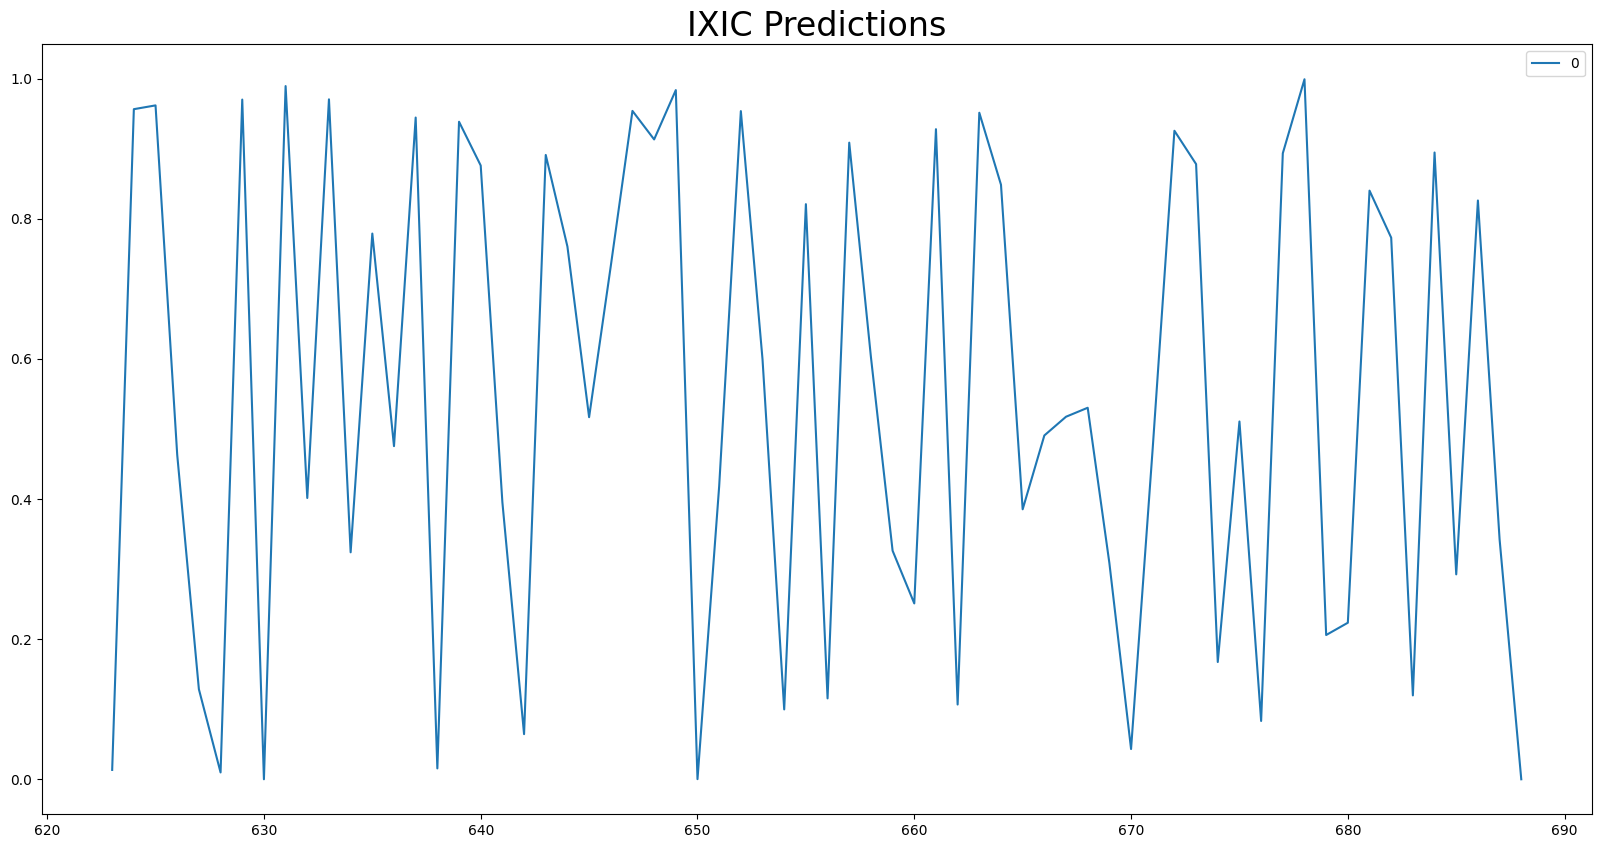

In [65]:
# Plot the predictions for last 66 working days(last 3 months) of current model to interpret the volatility of the IXIC index
# plot using dnn_test_predictions - probability values between 0 and 1 returned by sigmoid function in output layer
pd.DataFrame(dnn_test_predictions)[-66:].plot(figsize=(20,10))
plt.title('IXIC Predictions', fontsize=24)
plt.show()

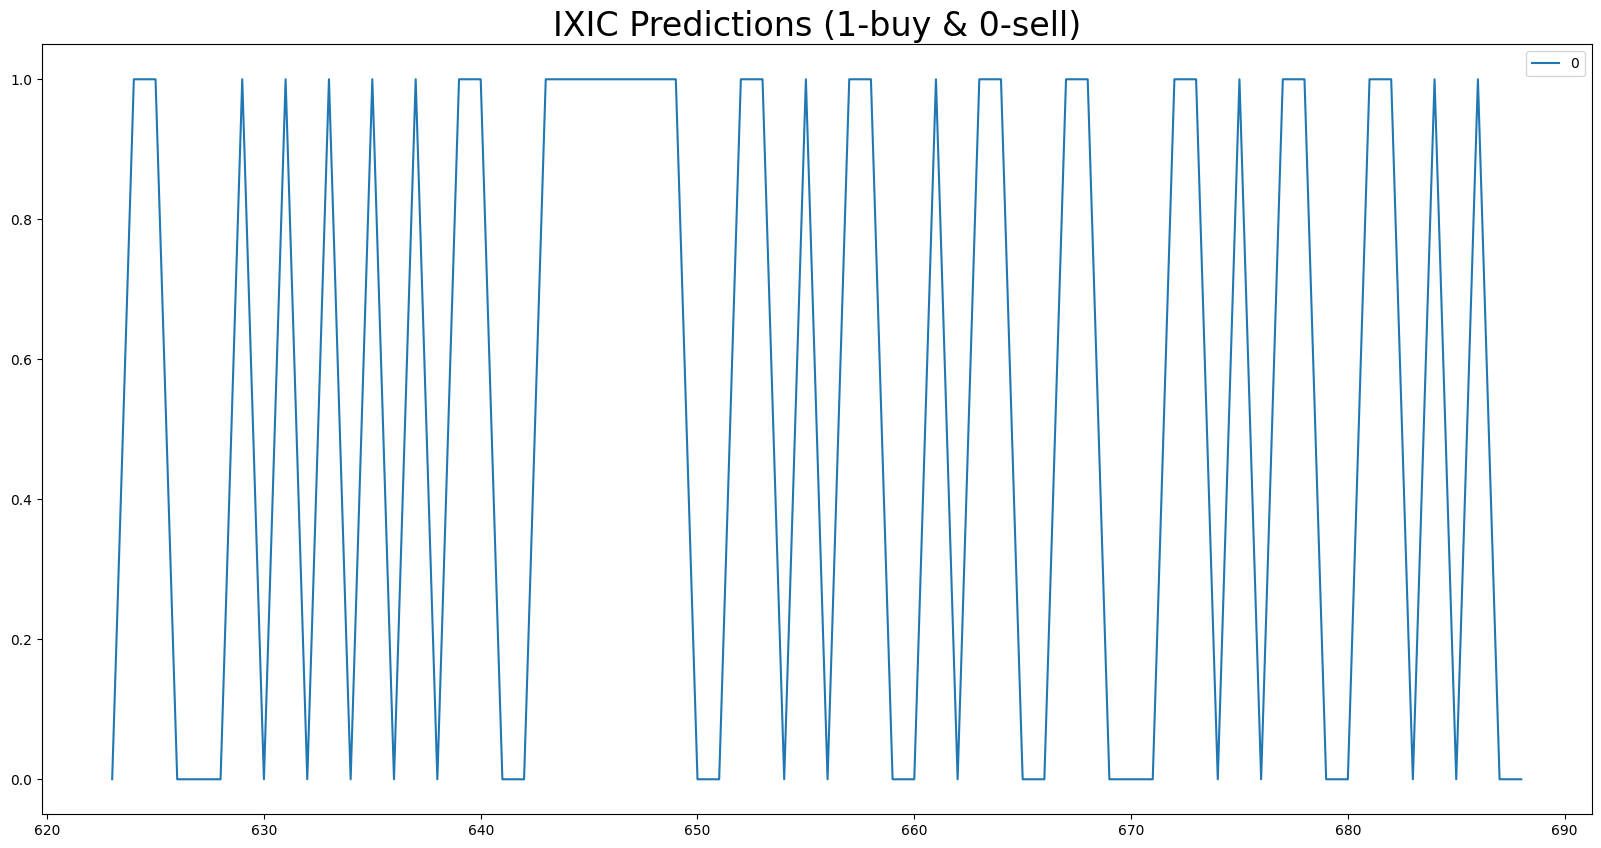

In [66]:
# Plot the predictions for last 66 working days(last 3 months) of current model to interpret the volatility of the IXIC index
# plot using dnn_binary_predictions - predictions explicitly classified to 0 and 1
# provides better visualization

pd.DataFrame(dnn_binary_predictions)[-66:].plot(figsize=(20,10))
plt.title('IXIC Predictions (1-buy & 0-sell)', fontsize=24)  # Adjust the fontsize as needed
plt.show()

**Question** - How can the market volatility be interpreted using this machine learning model?  

**Answer** - If the model is giving buy(1) and sell(0) indications every day or too frequently, that means market is volatile.
If the market is volatile, potential investors should refrain from investing in the stock market.



# **DNN Optimizer (IXIC)**


In [67]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 8.9 MB/s eta 0:00:00


In [68]:
def create_model(hp):
    nn_model5 = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    parLen=33
    # Allow kerastuner to decide number of neurons in first layer
    nn_model5.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=parLen, #As per recommendations, first layer neurons should atleast be equal to the number of features
        max_value=parLen*4,
        step=2), activation=activation, input_dim=parLen))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 4)):
        nn_model5.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=int(parLen/2),
            max_value=parLen*2,
            step=2),
            activation=activation))

    nn_model5.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model5.compile(loss="binary_crossentropy", metrics=["accuracy"],
                              optimizer=tf.keras.optimizers.Adam(
                              learning_rate=hp.Choice('learning_rate', values=[0.0001*x for x in range(1,7)])))

    return nn_model5

In [69]:
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2,
    project_name='ml_project_IXIC'  # Project name
)

In [70]:
# Search for the best hyperparameters
tuner.search(Xtrain, Ytrain,
             epochs=20,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[32, 64]),
             validation_data=(Xval, Yval))



Trial 180 Complete [00h 00m 22s]
val_accuracy: 0.6148256063461304

Best val_accuracy So Far: 0.6569767594337463
Total elapsed time: 00h 36m 29s


In [71]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(Xtest,Ytest,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


22/22 - 2s - 105ms/step - accuracy: 0.6676 - loss: 0.6484
Loss: 0.6483951807022095, Accuracy: 0.6676342487335205
22/22 - 2s - 102ms/step - accuracy: 0.6575 - loss: 0.6723
Loss: 0.6722738146781921, Accuracy: 0.6574745774269104
22/22 - 3s - 127ms/step - accuracy: 0.6212 - loss: 0.6696
Loss: 0.6696034669876099, Accuracy: 0.6211901307106018


In [72]:
# Retrieve all trials from the tuner
trials = tuner.oracle.get_best_trials(num_trials=10)

# Extract the trial details
val_accuracies = []

for trial in trials[::-1]:
    # Retrieve the best validation accuracy achieved in each trial
    val_accuracy = trial.metrics.get_best_value("val_accuracy")
    val_accuracies.append(val_accuracy)

# Assign numerical order to trials
trial_numbers = list(range(1, len(val_accuracies) + 1))

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Trial Number': trial_numbers,
    'Validation Accuracy': val_accuracies
})

# Plot using Plotly for an interactive graph
fig = px.line(df, x='Trial Number', y='Validation Accuracy', markers=True, title='Keras Tuner Optimization Results')
fig.update_layout(xaxis_title='Trial Number', yaxis_title='Validation Accuracy')
fig.show()


# **NN Ensemble (IXIC)** - Average of Top DNN models
Another strategy to optimize the model

In [73]:
# Ensemble the results of top models by averaging
if len(os.listdir(flpath))<5:

  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.74311_55.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_05_32_0.0001_0.74456_200.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/refs/heads/main/Resources/IXIC_models/model_11_10_32_0.0001_0.74311_129.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_10_32_0.0001_0.74601_158.h5"


prDict={}
mdlCnt=0


for mdl in os.listdir(flpath):
  if 'model_' not in mdl:
    continue
  print('model loaded from directory', mdl)
  nn.load_weights(flpath+mdl)
  prdc= nn.predict(Xtest)
  binary_predictions = (prdc > 0.5).astype(int)
  prDict[mdlCnt]=binary_predictions
  mdlCnt+=1


# Find the avergae of top dnn models and create a new predictions array
avgPrdc=[]
for i in range(len(prdc)):
  tmpVal=0
  for x in prDict.keys():
      tmpVal+=prDict[x][i]
  avgPrdc.append(tmpVal/len(prDict))
avgPrdc_binary = [(1 if x>0.5 else 0) for x in avgPrdc ]


--2025-01-06 14:13:21--  https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.74311_55.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.74311_55.h5 [following]
--2025-01-06 14:13:21--  https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/IXIC_models/model_11_01_32_0.0001_0.74311_55.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222764 (218K) [application/octet-stream]
Saving to: ‘/content/saved_models_IXIC/model_

In [74]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, avgPrdc_binary)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, avgPrdc_binary)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, avgPrdc_binary))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,183,107
Actual 1,66,333


Accuracy Score : 0.7489114658925979
Classification Report
              precision    recall  f1-score   support

           0       0.73      0.63      0.68       290
           1       0.76      0.83      0.79       399

    accuracy                           0.75       689
   macro avg       0.75      0.73      0.74       689
weighted avg       0.75      0.75      0.75       689



# **NN Ensemble (IXIC)** - Stack Top DNN models in a SVC meta model

Another strategy to optimize the model

In [75]:
# Step 1: Load the 5 saved models
from tensorflow.keras.models import load_model
models = [load_model(flpath+path) for path in os.listdir(flpath) if 'model_' in path]

# Step 2: Generate predictions for the training and test sets
def generate_ensemble_predictions(models, data):
    """Generate predictions from all models and stack them."""
    predictions = [model.predict(data) for model in models]
    return np.hstack(predictions)  # Combine predictions as features

# Assume Xtrain, Xtest, Ytrain, Ytest are your datasets
train_ensemble = generate_ensemble_predictions(models, Xtrain)
test_ensemble = generate_ensemble_predictions(models, Xtest)

# Step 3: Train the SVC meta-model
svc_meta = SVC(kernel='rbf', verbose=1)
svc_meta.fit(train_ensemble, Ytrain)

# Step 4: Evaluate the SVC meta-model
test_predictions = svc_meta.predict(test_ensemble)

# Evaluate accuracy and classification report
accuracy = accuracy_score(Ytest, test_predictions)
print(f"Ensemble SVC Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(Ytest, test_predictions))

101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
101/101 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[LibSVM]Ensemble SVC Accuracy: 0.737300435413643
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.64      0.67       290
           1       0.76      0.80      0.78       399

    accuracy                           0.74       689
   macro avg       0.73      0.72      0.73       689
weighted avg       0.74      0.74      0.74       689



The code in the following cells pertains to the NYA Stock Index Modelling.


# **Data Prep For ML (NYA)**

In [76]:
# start with the pandas dataframe containing all the data
data = stock_data.toPandas()
data.head()

,Index,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0


In [77]:
# Rename Index to ticker as it is the more commonly used name for stock market indexes in the United States
data = data.rename(columns={'Index': 'ticker'})
data.head()

,ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0


In [78]:
# Filter NYA data, reset index of the dataframe
idx_name = 'NYA'
dfNYA=data[data.ticker==idx_name]
dfNYA.reset_index(inplace=True)
dfNYA.drop('index',axis=1,inplace=True)
dfNYA


,ticker,Date,Open,High,Low,Close,Adj Close,Volume
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0
...,...,...,...,...,...,...,...,...
13943,NYA,2021-05-24,16375,16508.51953,16375,16464.68945,16464.68945,2947400000
13944,NYA,2021-05-25,16464.68945,16525.81055,16375.15039,16390.18945,16390.18945,3420870000
13945,NYA,2021-05-26,16390.18945,16466.33984,16388.32031,16451.96094,16451.96094,3674490000
13946,NYA,2021-05-27,16451.96094,16546.35938,16451.96094,16531.94922,16531.94922,5201110000


In [79]:
# Convert 'Close' column to numeric, handling 'null' values
dfNYA['Adj Close'] = pd.to_numeric(dfNYA['Adj Close'], errors='coerce')

# Drop rows with NaN values in 'Close' to avoid calculation errors
dfNYA = dfNYA.dropna(subset=['Adj Close'])

# Feature Engineering
# Calculate MACD, Signal, and RSI to add these as additional Features to improve the data to train the ML model.
# These features provide data moving trends which are useful for prediction.
# These are technical indicators which are usually used for trend analysis.

dfNYA['MACD'] = pd.DataFrame.ewm(dfNYA['Adj Close'], span=12, min_periods=12).mean() - pd.DataFrame.ewm(dfNYA['Adj Close'], span=26, min_periods=26).mean()
dfNYA['Signal'] = pd.DataFrame.ewm(dfNYA['MACD'], span=9, min_periods=9).mean()
dfNYA['RSI'] = pd.DataFrame.ewm(dfNYA['Adj Close'], span=14, min_periods=14).mean()

dfNYA.head()

,ticker,Date,Open,High,Low,Close,Adj Close,Volume,MACD,Signal,RSI
0,NYA,1965-12-31,528.690002,528.690002,528.690002,528.690002,528.690002,0,NaN,NaN,NaN
1,NYA,1966-01-03,527.210022,527.210022,527.210022,527.210022,527.210022,0,NaN,NaN,NaN
2,NYA,1966-01-04,527.840027,527.840027,527.840027,527.840027,527.840027,0,NaN,NaN,NaN
3,NYA,1966-01-05,531.119995,531.119995,531.119995,531.119995,531.119995,0,NaN,NaN,NaN
4,NYA,1966-01-06,532.070007,532.070007,532.070007,532.070007,532.070007,0,NaN,NaN,NaN


In [80]:
# Convert 'Volume' column to numeric before comparison
dfNYA['Volume'] = pd.to_numeric(dfNYA['Volume'], errors='coerce')

# Drop rows with NaN values in 'Volume' to avoid further errors
dfNYA = dfNYA.dropna(subset=['Volume'])

# Apply further filters
# Data was unclean for dates before Jan 8, 2003 as per data exploration observation.
# Filter to select records from 2003-03-01 so that the technical indicators that use previous months data are calculated properly
# Also second quarter of 2003 is a logical start of stock market data.

# Observation - Open price and close price for NYA index was same before this date.

dfCln=dfNYA[(pd.to_datetime(dfNYA['Date'])>pd.to_datetime('2003-03-01'))&(dfNYA['Volume']>0)].copy()
dfCln['Date']=pd.to_datetime(dfCln['Date'])
dfCln.reset_index(inplace=True)
dfCln.drop('index',axis=1,inplace=True)

In [81]:
# Taking copy to keep the original data safe before dropping columns not required for training
dfTrn = dfCln.copy()
dfTrn.drop(['ticker', 'Close'], axis=1, inplace=True)

# Convert necessary columns to numeric
numeric_cols = ['Open', 'High', 'Low', 'Adj Close', 'Volume', 'MACD', 'Signal', 'RSI']
dfTrn[numeric_cols] = dfTrn[numeric_cols].apply(pd.to_numeric, errors='coerce')
dfCln[numeric_cols] = dfCln[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [82]:
 # Initializing Target column with 0
dfTrn['Target'] = [0 for x in range(dfTrn.shape[0])]

## **Custom Scaling of Features**  

**Reasoning** - To avoid use of Standard Scalar.  
In this time series data, applying the StandardScaler on the entire training set can inadvertently introduce a form of "future influence" within the training data. This happens because the scaler computes the mean (μ\muμ) and standard deviation (σ\sigmaσ) for the entire training period, including all time points, even though later time points might not be available during earlier predictions in a real-world scenario.
This situation can lead to temporal data leakage within the training set itself, which undermines the validity of the model.


In [83]:
# Custom Scaling - Scale Features data to similiar numbers so that all are in close domain to train ML Model
# A close domain is good for model training as it will prevent biases for features which have comparatively larger values like Volume


# Convert all the feature variables in a close domain by dividing current day(r) value with the previous day(r-1) value.

for r in range(1, dfCln.shape[0]-1):
    if dfCln.loc[r - 1, 'Volume'] == 0:
        print(dfCln[r - 1:r][['Date', 'Open', 'High', 'Low', 'Adj Close', 'Volume', ]])
        continue
    #dfTrn.loc[r, 'Date'] = dfCln.loc[r, 'Date']
    dfTrn.loc[r, 'Open'] = dfCln.loc[r, 'Open'] / dfCln.loc[r - 1, 'Open']
    dfTrn.loc[r, 'High'] = dfCln.loc[r, 'High'] / dfCln.loc[r - 1, 'High']
    dfTrn.loc[r, 'Low'] = dfCln.loc[r, 'Low'] / dfCln.loc[r - 1, 'Low']
    dfTrn.loc[r, 'Adj Close'] = dfCln.loc[r, 'Adj Close'] / dfCln.loc[r - 1, 'Adj Close']
    dfTrn.loc[r, 'Volume'] = dfCln.loc[r, 'Volume'] / dfCln.loc[r - 1, 'Volume']
    dfTrn.loc[r, 'MACD'] = dfCln.loc[r, 'MACD'] / dfCln.loc[r - 1, 'MACD']
    dfTrn.loc[r, 'Signal'] = dfCln.loc[r, 'Signal'] / dfCln.loc[r - 1, 'Signal']
    dfTrn.loc[r, 'RSI'] = dfCln.loc[r, 'RSI'] / dfCln.loc[r - 1, 'RSI']

    # calculate Target variable for next day by comparing Open price of current day with the next day
    # If next day value is > current day value, set Target to 1
    dfTrn.loc[r,'Target']=1 if dfCln.loc[r+1,'Open']>dfCln.loc[r,'Open'] else 0



In [84]:
# Feature Engineering
# Enhance each row to have a weeks worth of data for all columns to embed one week long history in each record.
# This will help model in calculating the trend of Target variable.
#The number of weeks considered here is a hyperparameter which can be tuned.
for row in range(5,dfTrn.shape[0]):
  for cl in ['Open', 'High', 'Low', 'Adj Close', 'Volume']:
    for pdays in range(5):
      dfTrn.loc[row,cl+str(pdays)]=dfTrn.loc[row-pdays,cl]


In [85]:
# Remove first five records which don't have values for previous 5 day history
dfTrn=dfTrn[5:]
#verify successful removal
dfTrn[0:10]


,Date,Open,High,Low,Adj Close,Volume,MACD,Signal,RSI,Target,...,Adj Close0,Adj Close1,Adj Close2,Adj Close3,Adj Close4,Volume0,Volume1,Volume2,Volume3,Volume4
5,2003-03-10,1.004125,0.999548,0.989021,0.975021,0.886285,1.125095,1.013725,0.995320,0,...,0.975021,1.004125,0.989788,1.007697,0.984854,0.886285,1.055328,0.961441,1.118498,0.995450
6,2003-03-11,0.975021,0.981182,0.993930,0.993502,1.179527,1.109013,1.033814,0.995085,0,...,0.993502,0.975021,1.004125,0.989788,1.007697,1.179527,0.886285,1.055328,0.961441,1.118498
7,2003-03-12,0.993493,0.987255,0.982289,0.997124,1.134692,1.078819,1.043993,0.995348,0,...,0.997124,0.993502,0.975021,1.004125,0.989788,1.134692,1.179527,0.886285,1.055328,0.961441
8,2003-03-13,0.997133,1.028031,1.015408,1.030871,1.121173,0.914861,1.013813,0.999941,1,...,1.030871,0.997124,0.993502,0.975021,1.004125,1.121173,1.134692,1.179527,0.886285,1.055328
9,2003-03-14,1.030871,1.012033,1.028861,1.003550,0.845840,0.898720,0.989540,1.000422,1,...,1.003550,1.030871,0.997124,0.993502,0.975021,0.845840,1.121173,1.134692,1.179527,0.886285
10,2003-03-17,1.003550,1.021919,0.998776,1.030662,0.125561,0.736620,0.941095,1.004465,1,...,1.030662,1.003550,1.030871,0.997124,0.993502,0.125561,0.845840,1.121173,1.134692,1.179527
11,2003-03-18,1.030666,1.004584,1.031218,1.003388,8.061690,0.683161,0.902424,1.004317,1,...,1.003388,1.030662,1.003550,1.030871,0.997124,8.061690,0.125561,0.845840,1.121173,1.134692
12,2003-03-19,1.003384,1.008446,1.007755,1.009418,0.947463,0.521911,0.859236,1.005016,1,...,1.009418,1.003388,1.030662,1.003550,1.030871,0.947463,8.061690,0.125561,0.845840,1.121173
13,2003-03-20,1.009418,1.005251,0.996473,1.002285,0.976721,0.222436,0.815335,1.004640,1,...,1.002285,1.009418,1.003388,1.030662,1.003550,0.976721,0.947463,8.061690,0.125561,0.845840
14,2003-03-21,1.002289,1.020349,1.017179,1.023577,1.039191,-4.004386,0.724685,1.007241,1,...,1.023577,1.002285,1.009418,1.003388,1.030662,1.039191,0.976721,0.947463,8.061690,0.125561


In [86]:
# Segregate Features and Target - drop columns which are not required for training

dfFeature=dfTrn.drop(['Target','Date'],axis=1).values
dfTarget=dfTrn['Target'].values


In [87]:
# Spliting data in Training and Test in 70%,30% ratio which is usually done for machine learning
# Custom scaled data used - No standard scaler used
Xtrain,Xtest=train_test_split(dfFeature,test_size=0.3,shuffle=False)
Ytrain,Ytest=train_test_split(dfTarget,test_size=0.3,shuffle=False)

# **Logistic Regression (NYA)**

In [88]:
# Initialize logistic regression model
log_reg_model = LogisticRegression(max_iter=1000, class_weight='balanced')

# Train the model
log_reg_model.fit(Xtrain, Ytrain)


LogisticRegression(class_weight='balanced', max_iter=1000)

In [89]:
# Predict the target for test data
lrg_test_predictions = log_reg_model.predict(Xtest)


In [90]:
accuracy = accuracy_score(Ytest, lrg_test_predictions )
print(f"Accuracy: {accuracy}")


Accuracy: 0.7215743440233237


In [91]:
cm = confusion_matrix(Ytest, lrg_test_predictions)
print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[409 189]
 [193 581]]


In [92]:
report = classification_report(Ytest, lrg_test_predictions)
print("Classification Report:")
print(report)


Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.68      0.68       598
           1       0.75      0.75      0.75       774

    accuracy                           0.72      1372
   macro avg       0.72      0.72      0.72      1372
weighted avg       0.72      0.72      0.72      1372



# **Decision Tree (NYA)**

In [93]:
# Decision Tree
X = dfFeature
y = dfTarget
X = pd.DataFrame(X)  # Ensure X is a DataFrame
X = X.apply(pd.to_numeric, errors='coerce')  # Convert to numeric
X.fillna(X.mean(), inplace=True)  # Handle missing values


In [94]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3, random_state=42)


In [95]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt_model.fit(Xtrain, Ytrain)

DecisionTreeClassifier(class_weight='balanced', random_state=42)

In [96]:
# Predict the target for test data
dtr_test_predictions = dt_model.predict(Xtest)


In [97]:
accuracy = accuracy_score(Ytest, dtr_test_predictions)
print(f"Accuracy: {accuracy}")


Accuracy: 0.8185131195335277


In [98]:
print("Confusion Matrix:")
print(confusion_matrix(Ytest, dtr_test_predictions))


Confusion Matrix:
[[495 135]
 [114 628]]


In [99]:
print("Classification Report:")
print(classification_report(Ytest, dtr_test_predictions))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       630
           1       0.82      0.85      0.83       742

    accuracy                           0.82      1372
   macro avg       0.82      0.82      0.82      1372
weighted avg       0.82      0.82      0.82      1372



# **Random Forest (NYA)**

In [100]:
 # Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

In [101]:
# Fitting the model
rf_model = rf_model.fit(Xtrain, Ytrain)

In [102]:
 # Making predictions using the testing data
rfr_test_predictions = rf_model.predict(Xtest)

In [103]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, rfr_test_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, rfr_test_predictions)

In [104]:
 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, rfr_test_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,547,83
Actual 1,73,669


Accuracy Score : 0.8862973760932945
Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       630
           1       0.89      0.90      0.90       742

    accuracy                           0.89      1372
   macro avg       0.89      0.88      0.89      1372
weighted avg       0.89      0.89      0.89      1372



# **Ensemble (NYA) - Traditional Models**
Stacking the results of the three models - Logistic Regression, Decision Tree, and Random Forest in a meta- model.

**Reasoning** - To mitigate the weaknesses of these three models.  

The meta-model SVC learns from the diverse strengths and weaknesses of the 3 base models and forms a more balanced and well-generalized model.

In [105]:
from sklearn.svm import SVC

lrg_predictions=log_reg_model.predict(Xtrain)
dt_predictions=dt_model.predict(Xtrain)
rf_predictions=rf_model.predict(Xtrain)



In [106]:
# Combine predictions as inputs to the meta-model

stacked_X = np.vstack((lrg_predictions, dt_predictions, rf_predictions)).T
meta_model = SVC(kernel='poly', degree=10, C=1.0, coef0=1)
meta_model.fit(stacked_X, Ytrain)



SVC(coef0=1, degree=10, kernel='poly')

In [107]:
# Evaluate on test data

log_test_predictions = log_reg_model.predict_proba(Xtest)[:, 1]
dt_test_predictions = dt_model.predict_proba(Xtest)[:, 1]
rf_test_predictions = rf_model.predict_proba(Xtest)[:, 1]

stacked_test_X = np.vstack((log_test_predictions, dt_test_predictions, rf_test_predictions)).T
final_predictions=meta_model.predict(stacked_test_X)

meta_accuracy = accuracy_score(Ytest, final_predictions)
print(f" Accuracy: {meta_accuracy}")

 Accuracy: 0.7908163265306123


These models have less computational cost so we tried these but now trying DNN for a more robust model.

# **NEXT STRATEGY - Train a DNN model**
**Reasoning** - Even though DNN is computationally heavy but a well- tuned DNN model can generalize learnings more robustly with compared to other models. It can prove to be a better choice over the traditional models as the temporal dependencies and non-linear interactions between features are difficult for the traditional models to capture.

# **Deep Nerual Network (NYA)**

In [108]:
# Spliting data in Training,Validation and Test in 70%,15%,15% ratio which is usually done for machine learning.
# Shuffle is kept False to maintain the temporal consistencey of data
# In the second split, the first splitted portion will be val data and second will be the test data.
# This way the test data will be the one that is the closest to future data since it is a time series data.

Xtrain,Xtest=train_test_split(dfFeature,test_size=0.3,shuffle=False)
Ytrain,Ytest=train_test_split(dfTarget,test_size=0.3,shuffle=False)
Xval, Xtest=train_test_split(Xtest,test_size=0.5,shuffle=False)
Yval, Ytest=train_test_split(Ytest,test_size=0.5,shuffle=False)
print(len(Xtrain),len(Xval),len(Xtest))
print(len(Ytrain),len(Yval),len(Ytest))

3199 686 686
3199 686 686


In [109]:
len(Xtrain[0])

33

In [110]:
#Define callback setup
class SaveEveryNthEpoch(Callback):
    def __init__(self, n, filepath_template):
        super().__init__()
        self.n = n
        self.filepath_template = filepath_template

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n == 0:  # Check if the epoch is divisible by n
            filepath = self.filepath_template.format(epoch=epoch + 1)
            self.model.save(filepath)
            #print(f"Model saved to {filepath}")

In [111]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(Xtrain[0])
hidden_nodes_layer1 = number_input_features*4
hidden_nodes_layer2 = number_input_features*2
hidden_nodes_layer3 = number_input_features*1

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                      │ (None, 132)                 │           4,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 66)                  │           8,778 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 33)                  │           2,211 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              34 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,511 (60.59 KB)

 Trainable params: 15,511 (60.59 KB)

 Non-trainable params: 0 (0.00 B)

In [112]:
# Compile the model
bth=32
lr=0.0004
optimizer = Adam(learning_rate=lr)
save_every_epochs = SaveEveryNthEpoch(n=1, filepath_template="run_model_epoch_{epoch:02d}.h5")
nn.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])


In [113]:
 nn.fit(Xtrain,
          Ytrain,
          batch_size=bth,
          validation_data=(Xval,Yval),
          callbacks=[save_every_epochs],
          verbose=2,
          epochs=100)

Epoch 1/100
100/100 - 10s - 98ms/step - accuracy: 0.5364 - loss: 0.7006 - val_accuracy: 0.5598 - val_loss: 0.6867
Epoch 2/100
100/100 - 0s - 2ms/step - accuracy: 0.5470 - loss: 0.6936 - val_accuracy: 0.5481 - val_loss: 0.6890
Epoch 3/100
100/100 - 0s - 3ms/step - accuracy: 0.5411 - loss: 0.6898 - val_accuracy: 0.5569 - val_loss: 0.6871
Epoch 4/100
100/100 - 0s - 2ms/step - accuracy: 0.5524 - loss: 0.6860 - val_accuracy: 0.5539 - val_loss: 0.6891
Epoch 5/100
100/100 - 0s - 3ms/step - accuracy: 0.5549 - loss: 0.6854 - val_accuracy: 0.5408 - val_loss: 0.6900
Epoch 6/100
100/100 - 0s - 2ms/step - accuracy: 0.5483 - loss: 0.6863 - val_accuracy: 0.5583 - val_loss: 0.6895
Epoch 7/100
100/100 - 0s - 2ms/step - accuracy: 0.5452 - loss: 0.6862 - val_accuracy: 0.5423 - val_loss: 0.6908
Epoch 8/100
100/100 - 0s - 3ms/step - accuracy: 0.5564 - loss: 0.6826 - val_accuracy: 0.5569 - val_loss: 0.6868
Epoch 9/100
100/100 - 0s - 2ms/step - accuracy: 0.5508 - loss: 0.6828 - val_accuracy: 0.4621 - val_los

In [114]:
  # Evaluate the dnn model using the test data
  model_loss, model_accuracy = nn.evaluate(Xtest,Ytest,verbose=2)
  print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

22/22 - 0s - 2ms/step - accuracy: 0.6968 - loss: 15090960.0000
Loss: 15090960.0, Accuracy: 0.6967930197715759


In [115]:
# Commenting code as the required models have beed saved

# Saved top dnn models with model_accuracy > 0.75
flpath=f'/content/saved_models_{idx_name}/'
if not os.path.exists(flpath):
  os.mkdir(flpath)

for mdl in os.listdir():
  if 'run_model' not in mdl:
    continue
  nn.load_weights(mdl)
  model_loss, model_accuracy = nn.evaluate(Xtest,Ytest,verbose=0)
  if model_accuracy>0.75:
    nn.save(f"{flpath}/model_{datetime.now().strftime('%H_%M')}_{bth}_{lr}_{model_accuracy:.5f}_{mdl.split('_')[-1].replace('.h5','')}.h5")
    print(f"{mdl} Loss: {model_loss}, Accuracy: {model_accuracy} -- saved")
    os.remove(mdl)
  else:
    print(f"{mdl} Loss: {model_loss}, Accuracy: {model_accuracy} -- deleted")
    os.remove(mdl)


run_model_epoch_78.h5 Loss: 11432588.0, Accuracy: 0.6588921546936035 -- deleted
run_model_epoch_81.h5 Loss: 12130077.0, Accuracy: 0.6224489808082581 -- deleted
run_model_epoch_76.h5 Loss: 11461454.0, Accuracy: 0.6064140200614929 -- deleted
run_model_epoch_05.h5 Loss: 443359.15625, Accuracy: 0.5728862881660461 -- deleted
run_model_epoch_93.h5 Loss: 13579351.0, Accuracy: 0.7215743660926819 -- deleted
run_model_epoch_83.h5 Loss: 12321114.0, Accuracy: 0.6559766530990601 -- deleted
run_model_epoch_100.h5 Loss: 15090960.0, Accuracy: 0.6967930197715759 -- deleted
run_model_epoch_62.h5 Loss: 7273555.0, Accuracy: 0.6924198269844055 -- deleted
run_model_epoch_28.h5 Loss: 2241879.75, Accuracy: 0.581632673740387 -- deleted
run_model_epoch_48.h5 Loss: 4326213.5, Accuracy: 0.6195335388183594 -- deleted
run_model_epoch_51.h5 Loss: 4780890.5, Accuracy: 0.6311953067779541 -- deleted
run_model_epoch_20.h5 Loss: 1437817.25, Accuracy: 0.5932944416999817 -- deleted
run_model_epoch_54.h5 Loss: 5594334.5, Ac

In [116]:
#use saved model that was previuosly trained with >75% accuracy
# predict the outputs for the test dataset Xtest using the best trained neural network
#load the best model
import time
if not os.path.exists(flpath+'model_15_56_32_0.0004_0.75656_90.h5'):
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_15_56_32_0.0004_0.75656_90.h5"
  while  not os.path.exists(flpath+'model_15_56_32_0.0004_0.75656_90.h5'):
    time.sleep(1)
mdl=load_model(flpath+'model_15_56_32_0.0004_0.75656_90.h5')
dnn_test_predictions= mdl.predict(Xtest)



--2025-01-06 14:15:05--  https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_15_56_32_0.0004_0.75656_90.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/NYA_models/model_15_56_32_0.0004_0.75656_90.h5 [following]
--2025-01-06 14:15:05--  https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/NYA_models/model_15_56_32_0.0004_0.75656_90.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222764 (218K) [application/octet-stream]
Saving to: ‘/content/saved_models_NYA/model_15_5

In [117]:
# Convert to binary outputs
# Sigmoid activation function used in the output layer of this model returns the output (predictions) as a probability value between 0 and 1, not discrete values of 0 or 1.
# For binary predictions (0 or 1), post-process the output probabilities to classify them.

dnn_binary_predictions = (dnn_test_predictions > 0.5).astype(int)


In [118]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, dnn_binary_predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, dnn_binary_predictions)

 # Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, dnn_binary_predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,200,96
Actual 1,72,318


Accuracy Score : 0.7551020408163265
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.68      0.70       296
           1       0.77      0.82      0.79       390

    accuracy                           0.76       686
   macro avg       0.75      0.75      0.75       686
weighted avg       0.75      0.76      0.75       686



## **Model Predictions**
**Question** - What will be the change (higher or lower) in the opening price of the next day as compared to the opening price of the current day for the index NYA?

**Answer** - If the prediction for the Open Price of the next day is 1, it indicates that the Open price will increase so investor should buy the stock or hold any existing stock.
If the prediction for the Open Price of the next day is 0, it indicates that the Open price will deccrease so the investor should sell any existing stock.



## **Volatility Interpretation**

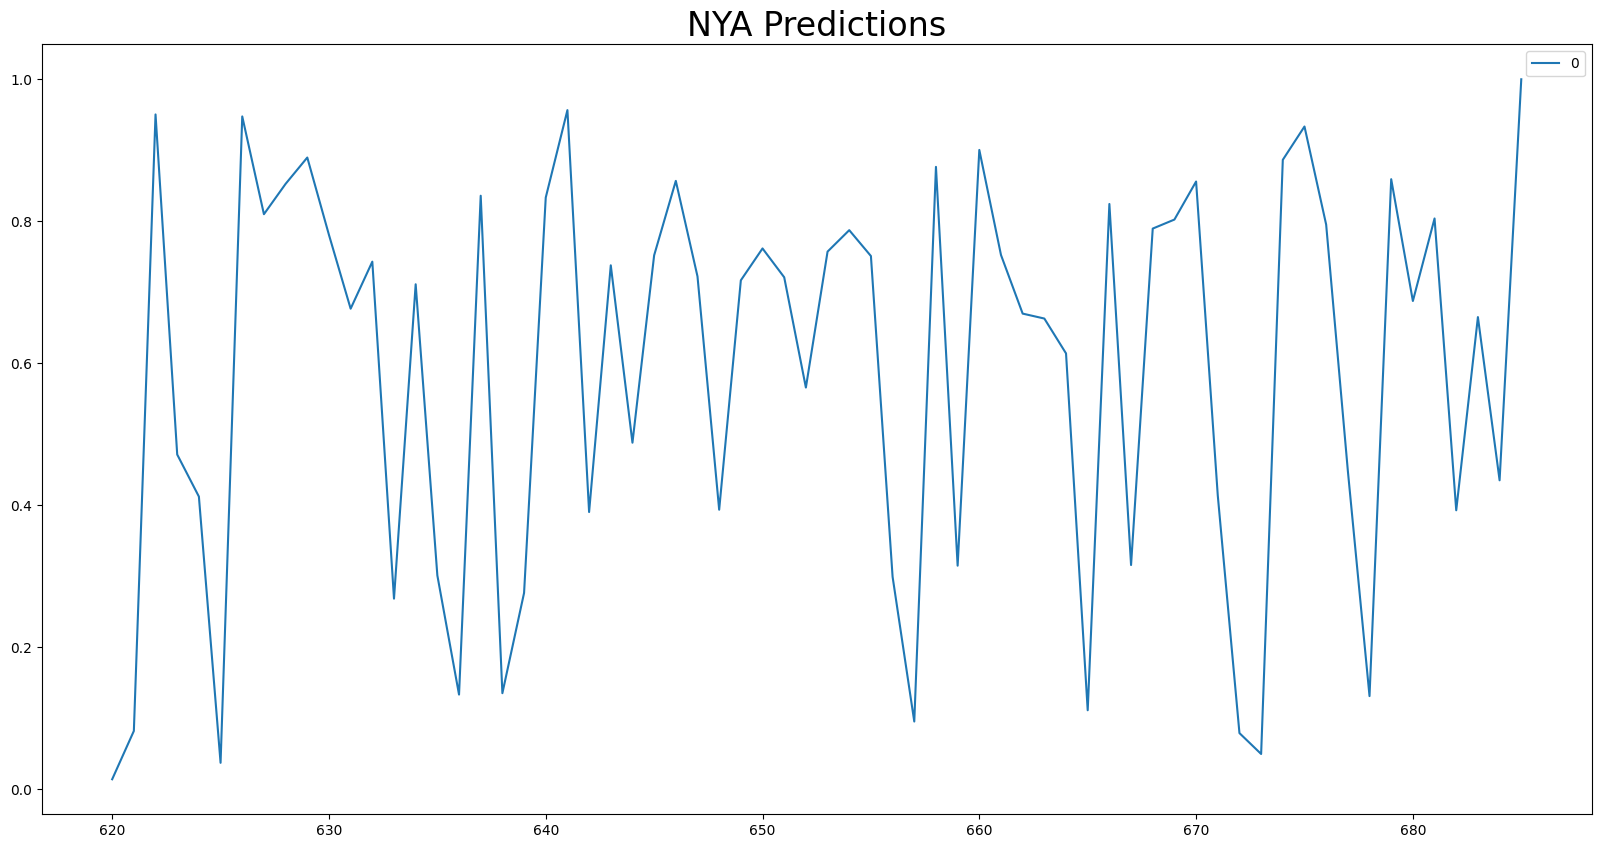

In [119]:
# Plot the predictions for last 66 working days(last 3 months) of current model to interpret the volatility of the NYA index
# plot using dnn_test_predictions - probability values between 0 and 1 returned by sigmoid function in output layer
pd.DataFrame(dnn_test_predictions)[-66:].plot(figsize=(20,10))
plt.title('NYA Predictions', fontsize=24)
plt.show()

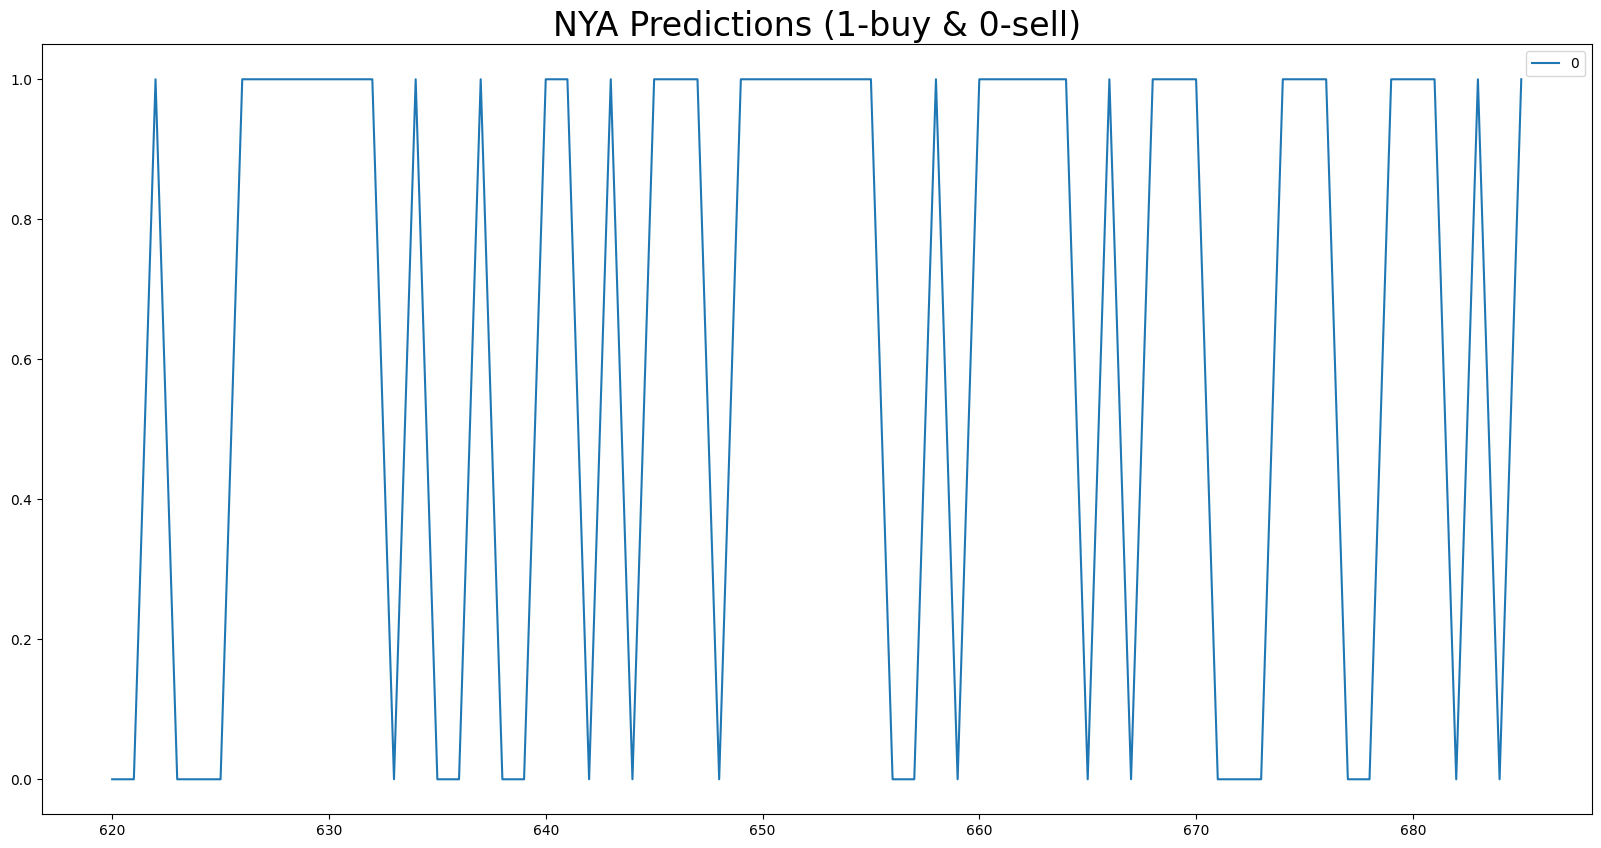

In [120]:
# Plot the predictions for last 66 working days(last 3 months) of current model to interpret the volatility of the NYA index
# plot using dnn_binary_predictions - predictions explicitly classified to 0 and 1
# provides better visualization

pd.DataFrame(dnn_binary_predictions)[-66:].plot(figsize=(20,10))
plt.title('NYA Predictions (1-buy & 0-sell)', fontsize=24)  # Adjust the fontsize as needed
plt.show()

**Question** - How can the market volatility be interpreted using this machine learning model?  

**Answer** - If the model is giving buy(1) and sell(0) indications every day or too frequently, that means market is volatile.
If the market is volatile, potential investors should refrain from investing in the stock market.



# **DNN Optimizer (NYA)**


In [121]:
!pip install keras-tuner

In [122]:
def create_model(hp):
    nn_model5 = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh','sigmoid'])
    parLen=33
    # Allow kerastuner to decide number of neurons in first layer
    nn_model5.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=parLen, #As per recommendations, first layer neurons should atleast be equal to the number of features
        max_value=parLen*4,
        step=2), activation=activation, input_dim=parLen))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model5.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=int(parLen/2),
            max_value=parLen*2,
            step=2),
            activation=activation))

    nn_model5.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model5.compile(loss="binary_crossentropy", metrics=["accuracy"],
                              optimizer=tf.keras.optimizers.Adam(
                              learning_rate=hp.Choice('learning_rate', values=[0.0001*x for x in range(1,20)])))

    return nn_model5

In [123]:
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=50,
    hyperband_iterations=2,
    project_name='ml_project_NYA'  # Project name
    )

In [124]:
# Search for the best hyperparameters
tuner.search(Xtrain, Ytrain,
             epochs=20,
             batch_size=tuner.oracle.hyperparameters.Choice('batch_size', values=[16, 32, 64, 128, 256]),
             validation_data=(Xval, Yval))



Trial 180 Complete [00h 00m 35s]
val_accuracy: 0.5612244606018066

Best val_accuracy So Far: 0.6763848662376404
Total elapsed time: 00h 57m 47s


In [125]:
# Evaluate the top 3 models against the test dataset
top_model = tuner.get_best_models(3)
for model in top_model:
    model_loss, model_accuracy = model.evaluate(Xtest,Ytest,verbose=2)
    print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")


22/22 - 3s - 139ms/step - accuracy: 0.6880 - loss: 0.6317
Loss: 0.631657600402832, Accuracy: 0.6880466341972351
22/22 - 4s - 192ms/step - accuracy: 0.7157 - loss: 0.6121
Loss: 0.6121031045913696, Accuracy: 0.7157434225082397
22/22 - 2s - 85ms/step - accuracy: 0.6647 - loss: 0.6566
Loss: 0.656624436378479, Accuracy: 0.6647230386734009


In [126]:
# Retrieve all trials from the tuner
trials = tuner.oracle.get_best_trials(num_trials=10)

# Extract the trial details
val_accuracies = []

for trial in trials[::-1]:
    # Retrieve the best validation accuracy achieved in each trial
    val_accuracy = trial.metrics.get_best_value("val_accuracy")
    val_accuracies.append(val_accuracy)

# Assign numerical order to trials
trial_numbers = list(range(1, len(val_accuracies) + 1))

# Create a DataFrame for visualization
df = pd.DataFrame({
    'Trial Number': trial_numbers,
    'Validation Accuracy': val_accuracies
})

# Plot using Plotly for an interactive graph
fig = px.line(df, x='Trial Number', y='Validation Accuracy', markers=True, title='Keras Tuner Optimization Results')
fig.update_layout(xaxis_title='Trial Number', yaxis_title='Validation Accuracy')
fig.show()


# **NN Ensemble (NYA)** - Average of Top DNN models
Another strategy to optimize the model

In [127]:
# Ensemble the results of top models by averaging
if len(os.listdir(flpath))<5:
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_24.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_40.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_66.h5"
  !wget -P {flpath} "https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_16_00_32_0.0004_0.75219_77.h5"

prDict={}
mdlCnt=0


for mdl in os.listdir(flpath):
  if 'model_' not in mdl:
    continue
  print('model loaded from directory', mdl)
  nn.load_weights(flpath+mdl)
  prdc= nn.predict(Xtest)
  binary_predictions = (prdc > 0.5).astype(int)
  prDict[mdlCnt]=binary_predictions
  mdlCnt+=1


# Find the avergae of top dnn models and create a new predictions array
avgPrdc=[]
for i in range(len(prdc)):
  tmpVal=0
  for x in prDict.keys():
      tmpVal+=prDict[x][i]
  avgPrdc.append(tmpVal/len(prDict))
avgPrdc_binary = [(1 if x>0.5 else 0) for x in avgPrdc ]


--2025-01-06 15:13:27--  https://github.com/Cenbull70/Group4_Project/raw/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_24.h5
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_24.h5 [following]
--2025-01-06 15:13:27--  https://raw.githubusercontent.com/Cenbull70/Group4_Project/refs/heads/main/Resources/NYA_models/model_14_41_32_0.0004_0.75073_24.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 222764 (218K) [application/octet-stream]
Saving to: ‘/content/saved_models_NYA/model_14_4

In [128]:
 # Calculating the confusion matrix
cm = confusion_matrix(Ytest, avgPrdc_binary)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(Ytest, avgPrdc_binary)

# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(Ytest, avgPrdc_binary))


Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,204,92
Actual 1,73,317


Accuracy Score : 0.7594752186588921
Classification Report
              precision    recall  f1-score   support

           0       0.74      0.69      0.71       296
           1       0.78      0.81      0.79       390

    accuracy                           0.76       686
   macro avg       0.76      0.75      0.75       686
weighted avg       0.76      0.76      0.76       686



# **NN Ensemble (NYA)** - Stack Top DNN models in a SVC meta model

Another strategy to optimize the model

In [129]:
# Step 1: Load the 5 saved models
from tensorflow.keras.models import load_model
models = [load_model(flpath+path) for path in os.listdir(flpath) if 'model_' in path]

# Step 2: Generate predictions for the training and test sets
def generate_ensemble_predictions(models, data):
    """Generate predictions from all models and stack them."""
    predictions = [model.predict(data) for model in models]
    return np.hstack(predictions)  # Combine predictions as features

# Assume Xtrain, Xtest, Ytrain, Ytest are your datasets
train_ensemble = generate_ensemble_predictions(models, Xtrain)
test_ensemble = generate_ensemble_predictions(models, Xtest)

# Step 3: Train the SVC meta-model
svc_meta = SVC(kernel='rbf', verbose=1)
svc_meta.fit(train_ensemble, Ytrain)

# Step 4: Evaluate the SVC meta-model
test_predictions = svc_meta.predict(test_ensemble)

# Evaluate accuracy and classification report
accuracy = accuracy_score(Ytest, test_predictions)
print(f"Ensemble SVC Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(Ytest, test_predictions))

100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[LibSVM]Ensemble SVC Accuracy: 0.7580174927113703
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.72      0.72       296
           1       0.79      0.78      0.79       390

    accuracy                           0.76       686
   macro avg       0.75      0.75      0.75       686
weighted avg       0.76      0.76      0.76       686



**Question** - Can a model be trained with near about 90% accuracy to be a potent advisor for investing in the stock market?  

**Answer** -


**Which model was closest to 90%?** Random Forest


**Can we rely on the model with highest accuracy?**


This model with the highest accuracy can be a potent advisor if it shows a consistent prediction close to 90% accuracy over time in different  market conditions.


**Should we rely on the model that is more robust and ensembled but probably with slightly lower accuracy scores?**


The alternative to that is a more robust and ensembled DNN model, while slightly less accurate, offers robustness and adaptability. For the NYA index, this model provides balanced predictions and performs well in capturing complex patterns.

